In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 13)


# Camera calibration

In [2]:
from glob import glob

def calibration_images():
    calibration_image_files = glob('camera_cal/calibration*.jpg')
    for fn in calibration_image_files:
        img = mpimg.imread(fn)
        yield cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
def find_chessboard_corners(images):
    board_size = (9, 6)
    obj_corners = np.array([[x, y, 0] for y in range(board_size[1]) for x in range(board_size[0])],
                          dtype=np.float32)

    obj_points = []
    image_points = []
    for img in calibration_images():
        ret, corners = cv2.findChessboardCorners(img, board_size, None)
        if ret: 
            obj_points.append(obj_corners)
            image_points.append(corners)
    
    return (obj_points, image_points)

def calibrate_camera(obj_points, image_points):
    calibration_image_size = (720, 1280)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, image_points, calibration_image_size, None, None)
        
    if ret: 
        return (mtx, dist)
    else:
        raise "Unable to calibrate camera"

def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


In [3]:
obj_points, image_points = find_chessboard_corners(calibration_images())
mtx, dist = calibrate_camera(obj_points, image_points)

# Testing calibration

In [23]:
def visualize_process_stage(orig_img, processed_img, 
                            orig_title='Original image', 
                            processed_title='Processed Image', 
                            orig_cmap=None,
                            processed_cmap=None,
                            output_file=None):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(orig_img, orig_cmap)
    axes[0].set_title(orig_title)

    axes[1].imshow(processed_img, processed_cmap)
    axes[1].set_title(processed_title)

    if (output_file):
        fig.savefig(output_file);



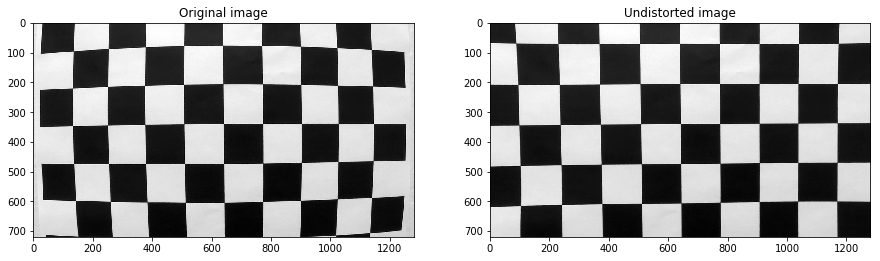

In [26]:
test_image = next(calibration_images())
undistorted_image = undistort_image(test_image, mtx, dist)
visualize_process_stage(test_image, undistorted_image, 
                        processed_title='Undistorted image',
                        orig_cmap='gray', processed_cmap='gray',
                        output_file='output/calibration_test.png')


# Image processing pipeline

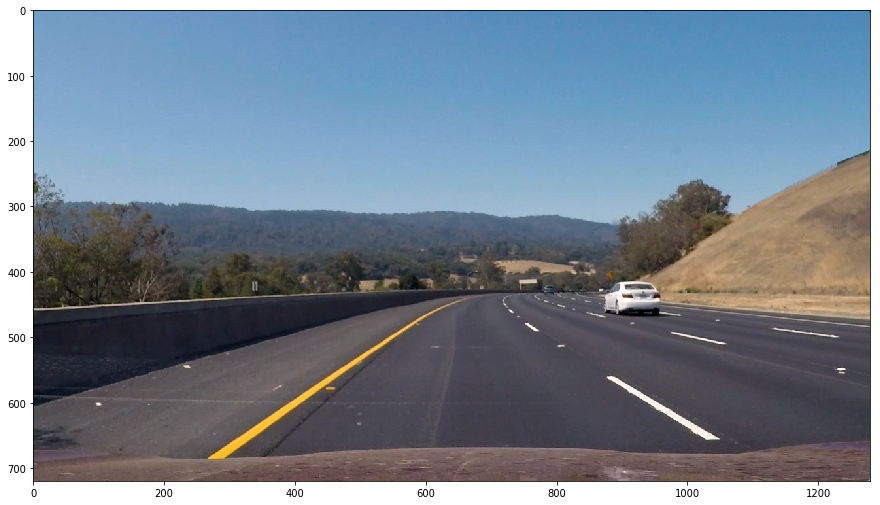

In [9]:
sample_image = mpimg.imread('./test_images/test3.jpg')
plt.imshow(sample_image)

In [31]:
def end_of_pipeline(img):
    return img


## Correcting distortion

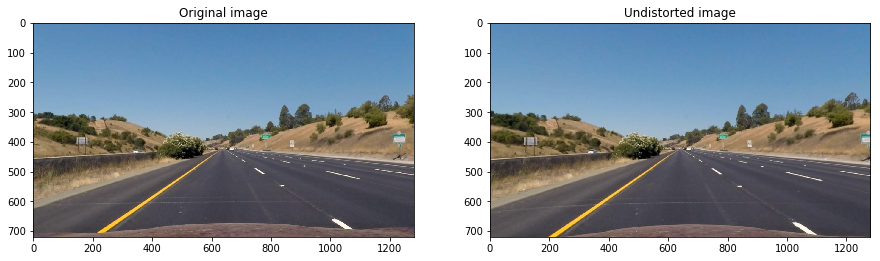

In [123]:
def correct_distortion(next_stage):
    def _process(image):
        undistorted = undistort_image(image, mtx, dist)
        return next_stage(undistorted)
    
    return _process

corrector = correct_distortion(end_of_pipeline)
processed_image = corrector(sample_image)

visualize_process_stage(sample_image, processed_image, 
                        processed_title='Undistorted image', 
                        output_file='output/undistorted.png')

## Thresholding

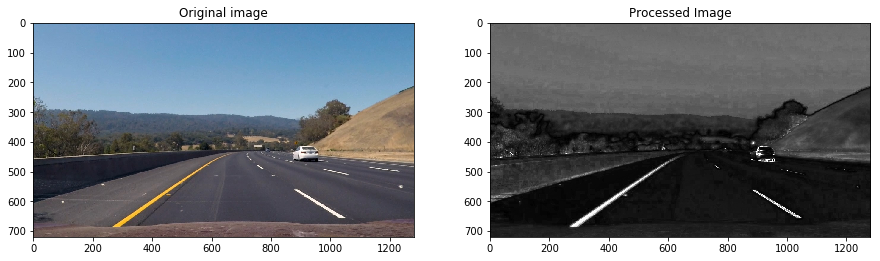

In [52]:
hls = cv2.cvtColor(sample_image, cv2.COLOR_RGB2HLS)
visualize_process_stage(sample_image, hls[:, :,2], processed_cmap='gray')

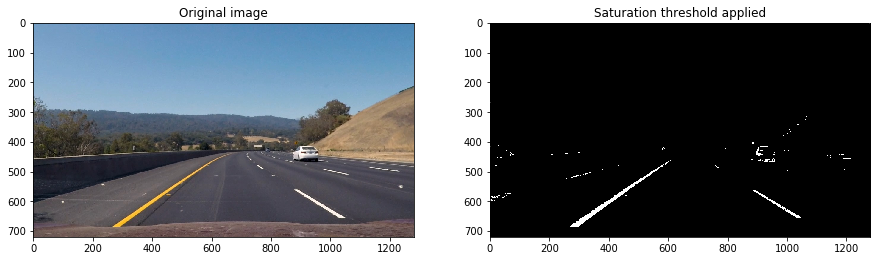

In [57]:
def saturation_threshold(lower, upper, next_stage):
    def _process(image):
        hsl = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        sat = hsl[:, :, 2]
        mask = np.zeros_like(sat)
        mask[(sat > lower) & (sat <= upper)] = 1
        return next_stage(mask)
    
    return _process

thresholder = saturation_threshold(120, 255, end_of_pipeline)
visualize_process_stage(sample_image, thresholder(sample_image),
                        processed_title='Saturation threshold applied', 
                        processed_cmap='gray',
                        output_file='output/saturation_threshold.png')

## Perspective transform

In [125]:
image_points = np.array([(245, 685), (613, 438), (665, 438), (1062, 685)], dtype=np.float32)
object_points = np.array([(245, 720), (245, 0), (1062, 0), (1062, 720)], dtype=np.float32)
perspective_mtx = cv2.getPerspectiveTransform(image_points, object_points)

def perspective_transform(next_stage):
    def _process(image):
        img_size = (image.shape[1], image.shape[0])
        processed = cv2.warpPerspective(image, perspective_mtx, img_size, flags=cv2.INTER_LINEAR)
        return next_stage(processed)
    
    return _process
    

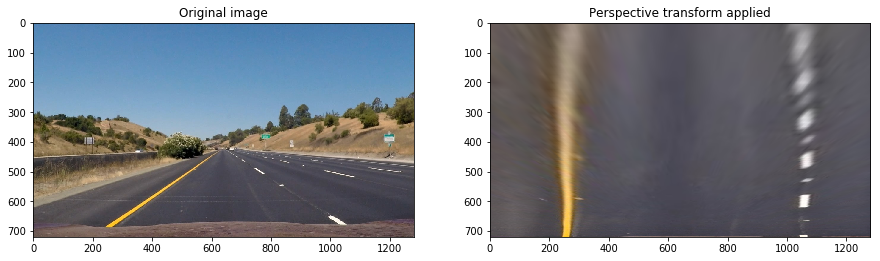

In [128]:
transform = perspective_transform(end_of_pipeline)

sample_image = mpimg.imread('./test_images/straight_lines1.jpg')
warped = transform(sample_image)
visualize_process_stage(sample_image, warped, processed_title='Perspective transform applied', 
                        output_file='output/perspective_transform.png')


# Video processing pipeline

In [64]:
import os.path as path
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def display_video(video_file):
    return HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))

def process_video(filename, processor_fn):
    clip = VideoFileClip(filename)
    processed = clip.fl_image(processor_fn)
    
    output_base = path.basename(filename)
    output_file = path.join('output', output_base)
    processed.write_videofile(output_file, audio=False)
    return output_file
    

In [133]:
processor = correct_distortion(perspective_transform(end_of_pipeline))


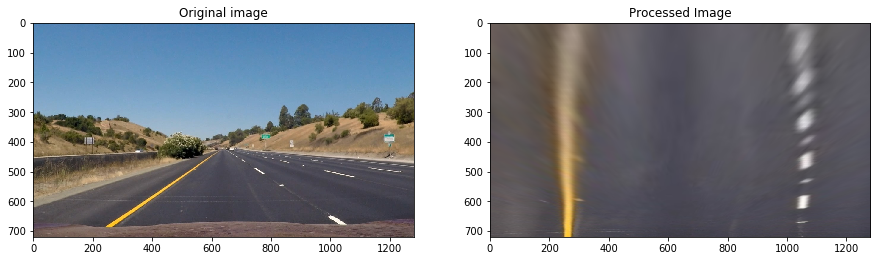

In [134]:
visualize_process_stage(sample_image, processor(processed_image), processed_cmap='gray')

In [135]:
input_file = './project_video.mp4'

output = process_video(input_file, processor)
display_video(output)


[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████▉| 1260/1261 [00:52<00:00, 23.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

